### Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок
- value – значения метрики
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style = 'whitegrid')

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep=";", decimal = ",", 
                 index_col=[0])

In [3]:
df.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [22]:
df.shape

(1000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


Делим данные на два варианта (control, treatment), берём только значения столбца 'value' для проведения А/В теста

In [6]:
sample1 = df.query('experimentVariant == "Control"').value

In [7]:
sample2 = df.query('experimentVariant == "Treatment"').value

Построим гистограмму чтобы посмотреть на распределение данных

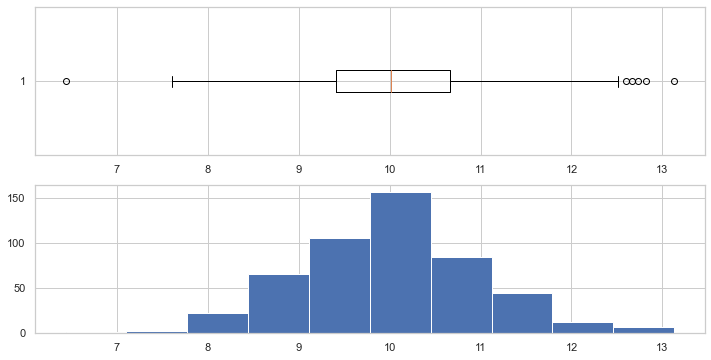

In [8]:
fig, ax = plt.subplots(2, 1)
ax[0].boxplot(sample1, vert=False)
ax[1].hist(sample1)
plt.show()

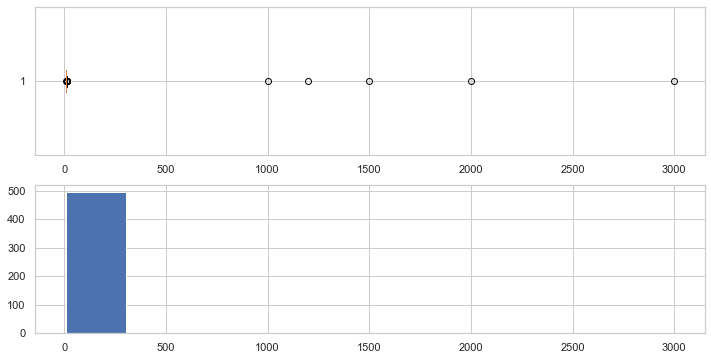

In [9]:
fig, ax = plt.subplots(2, 1)
ax[0].boxplot(sample2, vert=False)
ax[1].hist(sample2)
plt.show()

Отбросим выбросы, и вновь посмотрим на данные

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.histplot(sample2.loc[sample2 < sample2.quantile(.99)], ax=ax[0])
sns.histplot(sample1, ax=ax[1]);

Визуально распределение данных эксперимента 'control' напоминает нормальное, а в данных эксперимента 'treatment' есть выбросы. Без них данные почти что идентичны

Создаем функцию для проверки гипотезы с помощью бутстрапа

In [12]:
def get_bootstrap(sample1, sample2, iterate=1000, alpha=0.05, statistic='mean', random_state=42):
    
    assert statistic in ('mean', 'median'), f'{statistic} not in correct statistics. Choose "mean" or "median"'
    np.random.seed(random_state)
    l = max(len(sample1), len(sample2))
    difference = []
    for i in range(iterate):
        s1 = sample1.sample(l, replace=True).values
        s2 = sample2.sample(l, replace=True).values
        if statistic == 'mean':
            diff = np.mean(s1 - s2)
        else: 
            diff = np.median(s1 - s2)
        difference.append(diff)
    low_quantile = alpha/2
    upper_quantile = 1 - low_quantile 
    ci = (np.quantile(difference, low_quantile), np.quantile(difference, upper_quantile))
    p1 = norm.cdf(0, loc=np.mean(difference), scale=np.std(difference))
    p2 = 1 - p1
    p = min(p1, p2)*2
    
    plt.hist(difference, bins = 50)

    with plt.style.context('bmh'):
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": difference, 
            "ci": ci, 
            "p_value": p
           }

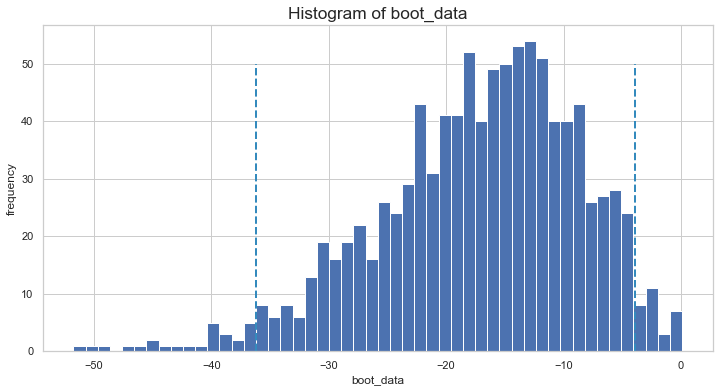

In [13]:
result_mean = get_bootstrap(sample1, sample2, statistic='mean')

In [14]:
result_mean['p_value']

0.04416084909119422

In [15]:
result_mean['ci']

(-36.216937678453895, -3.938252045027101)

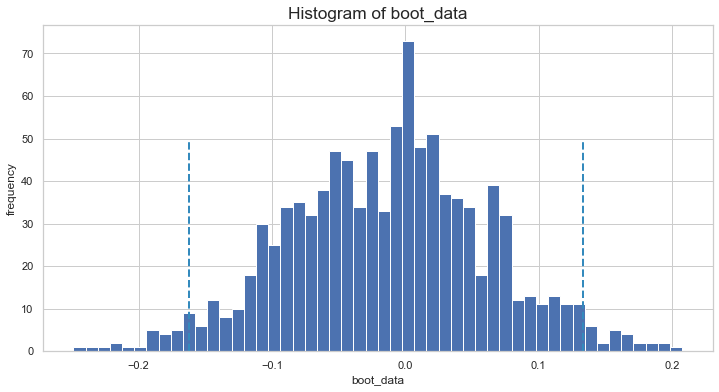

In [16]:
result_median = get_bootstrap(sample1, sample2, statistic='median')

In [17]:
result_median['p_value']

0.859136304741511

In [20]:
result_median['ci']

(-0.16258763394565295, 0.13354281056664588)

Применим непараметрический тест = критерий Манна-Уитни

In [19]:
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

**Выводы:**
- Тестовая выборка имеет большие выбросы, сильно искажающие среднее значение
- Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
- Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
- U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

На основе непараметрического анализа, мы принимаем нулевую гипотезу о том, что распределения отличаются не значительно и не нужно внедрять изменения.